Ce programme est pour but de résoudre la GPE: 
    $$
\mathrm{i} \frac{\partial}{\partial t} \varphi(x ; t)=\left[-\frac{\partial^2}{\partial x^2}+\frac{x^2}{4}+\mathcal{N}|\varphi(x ; t)|^2\right] \varphi(x ; t) \equiv H \varphi(x ; t)
$$

Pour tester le programme et implémenter la méthode de temps réel et de temps imaginaire, on ajoute deux paramètres w et R et résoudre numériquement équation:
   $$
 \frac{\partial}{\partial t} \varphi(x ; t)= R \left[-\frac{\partial^2}{\partial x^2}+w\frac{x^2}{4}+\mathcal{N}|\varphi(x ; t)|^2\right] \varphi(x ; t) \equiv H \varphi(x ; t)
$$
w est un nombre réelle, R = -$\mathrm{i}$ : méthode de temps réel; R = -1 méthode de temps imaginaire

Ici on utilise la méthode "Split-step", c'est à dire on sépare H en deux parties $H = H_{1} + H_{2}$
$$
H_{1} = R \left[w\frac{x^2}{4}+\mathcal{N}|\varphi(x ; t)|^2\right]
\\
H_{2} = R \left[-\frac{\partial^2}{\partial x^2}\right]
$$
On résout $\frac{\partial}{\partial t} \varphi(x ; t)= H_{1}\varphi(x ; t)$ en gardant $H_{1} $ est une constante et puis $\frac{\partial}{\partial t} \varphi(x ; t)= H_{2}\varphi(x ; t)$ par la méthode de spectrale

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy import signal
from scipy.interpolate import UnivariateSpline

class GPE1D:
    """A class that solves  du/dt = R* [- d^2(u)/(dt)^2 + [w*x^2/4 + N.u^2]*u]
    Spectral stepping method for solving PDEs"""
    def __init__(self, Nx, N, L,w,r = 1): 
        """Initialize the spatial and spectral grids
        If r = 1: method real time, if r = 0: method imaginary time"""
        self.Nx = Nx
        self.N = N
        self.L = L
        self.w = w
        self.x, self.dx = np.linspace(-self.L, self.L, self.Nx, retstep=True)
        self.k = 2*np.pi*np.fft.fftfreq(self.Nx, d=self.dx)        
        if r == 0:
            self.R = -1
        else:   
            self.R = -1j
        self.u = np.zeros(Nx,dtype = complex)

        
    def initialize(self, func):
        """Set the initial condition"""
        self.u = func(self.x)
        
    def set_vector(self,u):
        "set the initial condition by a vector u"
        self.u = u
        
    def normalisation(self):
        "normaliser vector u in order the integral of u^2 = 1"
        self.u = self.u/np.sqrt(np.linalg.norm(self.u)**2*self.dx)
    
    def FourierStep(self, dt):
        """Make a step dt forward in time for du/dt = -R*d^2(u)/dt^2"""
        uk = np.fft.fft(self.u)
        uk = np.exp(self.k**2 * dt*self.R)*uk
        self.u = np.fft.ifft(uk)
    
    def step(self,dt):
        """Make a step dt forward in time for i*du/dt = H.u"""
        self.FourierStep(dt)
        self.H1Step(dt)
        if self.R == -1:  #normalisation for imaginary time method
            self.u = self.u/np.sqrt(np.linalg.norm(self.u)**2*self.dx)

    def H1Step(self,dt): 
        """Make a step dt forward in time for i*du/dt = (w*x^2/4 + N.u^2)*u"""
        self.u = self.u * np.exp(self.R*(self.w*self.x**2/4 + self.N * abs(self.u)**2) * dt)
        
'''        
    def H1Step(self,dt):  #methode runga kutta ordre 4
        """Make a step dt forward in time for du/dt = R*[w*x^2/4 + N.u^2]*u"""
        
        if self.R == -1j:
            k1,k2,k3,k4 = np.zeros((4,self.Nx),dtype = complex)
        else:
            k1,k2,k3,k4 = np.zeros((4,self.Nx),dtype = float)
            
        N,w,R,x,u = self.N,self.w,self.R,self.x,self.u
        k1 = R*(w*x**2/4 + N * abs(u)**2)*dt* u
        k2 = R*(w*x**2/4 + N * abs(u+k1/2)**2)*dt* (u+k1/2)
        k3 = R*(w*x**2/4 + N * abs(u+k2/2)**2)*dt* (u+k2/2)
        k4 = R*(w*x**2/4 + N * abs(u+k3)**2)*dt* (u+k3)
        self.u += k1/6 + k2/3 + k3/3 + k4/6 
'''


def advance(GPE, dt, Nt): #Advance GPE Nt pas d'intervalle dt
    for _ in range(Nt):
        GPE.step(dt)

Now we will test our program with known solutions

We begin with the phenomen of spread of a gaussian wave packet with time to test $\frac{\partial}{\partial t} \varphi(x ; t)=\left[-\frac{\partial^2}{\partial x^2}\right] \varphi(x; t)$ (where $ \mathcal{N} = 0, \hbar /m =2,  w = 0$ using real time method)

We put 
$$
\psi(x, 0)=\frac{1}{\pi^{1 / 4} \sqrt{w_0}} \mathrm{e}^{-\frac{(x-x_0)^2}{2 w_0^2}} \mathrm{e}^{i k_0 (x-x_0)}
$$

as the initial condition, then after a latter time t, we will have 

$$
\psi(x, t)=\frac{\sqrt{w_0}}{\pi^{1 / 4} w(t)} \mathrm{e}^{-\frac{\left(x-x_0-k_0 t\right)^2}{2 w(t)^2}} \mathrm{e}^{i k_0\left(x-x_0-v_{\varphi} t\right)}
$$

where $v_{\varphi} = -k_0$ is angle velocity

The probability of presence $|\psi(x, t)|^2$ will eliminate the complex of the previous expression :
$$
|\psi(x, t)|^2=\frac{w_0}{\pi^{1 / 2} w(t)^2} \mathrm{e}^{-\frac{(x-x_0-k_0t)^2}{|w(t)|^2}}
$$

where as the spread of wave packet is given by
$$
{\left|w(t)^2\right|}= w_0^2 \left(1+4\frac{ t^2}{w_0^4}\right)
$$


ref: https://www.phys.upmc.fr/~araoux/documents/2020_AgregPhys_Quantique_TD2_corr.pdf

https://demonstrations.wolfram.com/SpreadOfAGaussianWavePacketWithTime/

In [2]:
class Gaussian_packet:
    """Gaussian function"""
    def __init__(self, w0, k0, x0):
        """Create Gaussian with the given width and amplitude, centered at x = x0"""
        self.w0 = w0
        self.k0 = k0
        self.x0 = x0
        
    def __call__(self, x):
        """Evaluate the function for the values of x"""
        return np.exp(-(x-self.x0)**2 /(2*self.w0**2) + self.k0*1j*(x-x0)) / (np.pi**0.25*np.sqrt(self.w0))
    
class Solution_at_T:
    def __init__(self, w0, k0, x0,T):
        """Create Gaussian with the given width and amplitude, centered at x = x0"""
        self.w0 = w0
        self.k0 = k0
        self.x0 = x0
        self.T = T
        
    def __call__(self, x):
        """Evaluate the function for the values of x"""
        k0 = self.k0
        w0 = self.w0
        T = self.T
        x0 = self.x0
        w2 = w0**2*(1+4*T**2/w0**4)
        return np.exp(-(x-x0-2*k0*T)**2/(w2))/(np.sqrt(np.pi)*np.sqrt(w2)) 
    
class Width2_theo:
    def __init__(self, w0):
        """Create square Gaussian width with the given initial width w0 to calculate w^2 = w0^2 (1+4*t^2/w0^4) """
        self.w0 = w0
    def __call__(self,t):
        return self.w0**2*(1+4*t**2/self.w0**4)
    
def FWHM(X,Y): 
    "Find half width of Y(X)"
    half_max = max(Y) / 2.
    for i in range(len(Y)):
        if Y[i]>half_max:
            left_idx = i
            break
    for i in range(len(Y)):
        if Y[len(Y)-1-i] > half_max:
            right_idx = len(Y)-1-i
            break
    return X[right_idx] - X[left_idx]  #return the difference (full width)

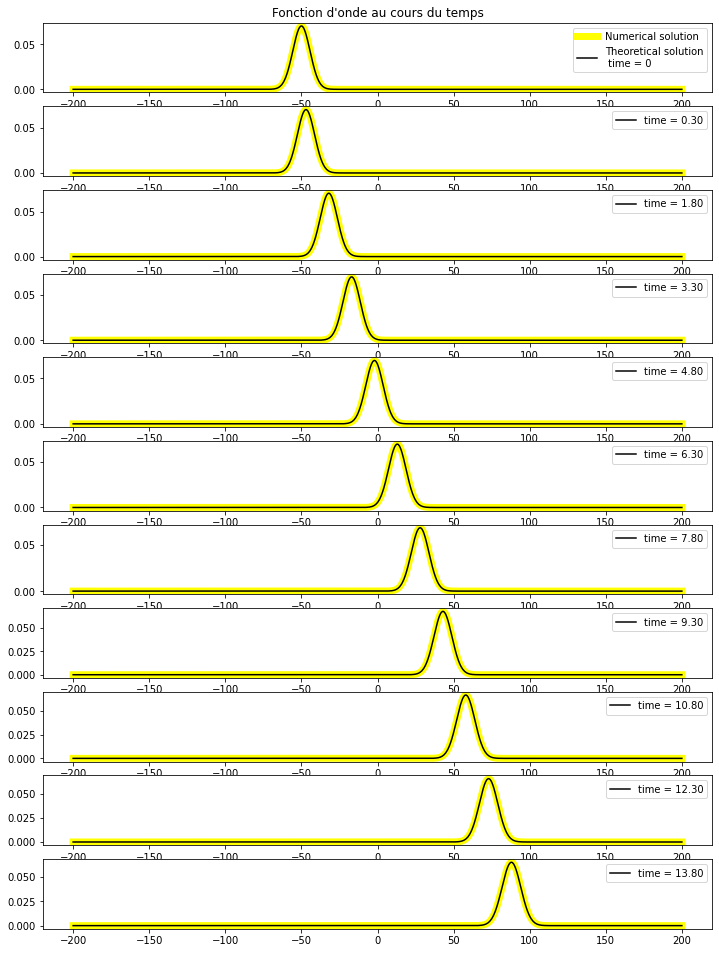

In [3]:
#Test for w = 0, N = 0, R = 0: étalement d'onde gaussienne

w = 0           # Valeur de w dans l'equation
N = 0        # Valeur de N dans l'equation
Nx = 200000      # Nombre de pas de x
L = 200        # x_max; dx = L/Nx
Nt = 100      # Nombre de pas de temps
dt = 0.003         # Intervalle de temp
dT = dt*Nt          # dT = Nt * dt
NT = 50    #Nombre de pas de T


# create a Gaussian object
w0 = 8
k0 = 5
x0 = -50
gauss = Gaussian_packet(w0,k0,x0)

GPE = GPE1D(Nx,N,L,w) # Create an GPE
GPE.initialize(gauss)
x = GPE.x

T,dT = np.linspace(0,NT*dt*Nt,NT+1,endpoint = True, retstep = True)
width = np.zeros(NT+1) # width caculated
width[0] = w0

fig, ax = plt.subplots((NT)//5+1,figsize=(12, NT/3))
ax[0].plot(x, np.abs(GPE.u)**2,"yellow", linewidth = 7.0,label='Numerical solution')
ax[0].plot(x,abs(gauss(x))**2, "black", label = "Theoretical solution\n time = 0")
ax[0].set_title("Fonction d'onde au cours du temps")
ax[0].legend()

# Evolve the wave function in time, we get the value of wave function each T(s) for NT times
for i in range(NT):
    sol = Solution_at_T(w0,k0,x0,T[i+1])
    advance(GPE,dt,Nt)
    width[i+1] = FWHM(x,abs(GPE.u)**2)/(2*np.sqrt(np.log(2)))  # width = FWHM/(2ln2)
    if i%5 == 0:
        ax[i//5+1].plot(x, abs(GPE.u)**2, "yellow", linewidth = 7.0)
        ax[i//5+1].plot(x,sol(x),"black", label = "time = {:.2f}".format(T[i+1]))
        ax[i//5+1].legend()

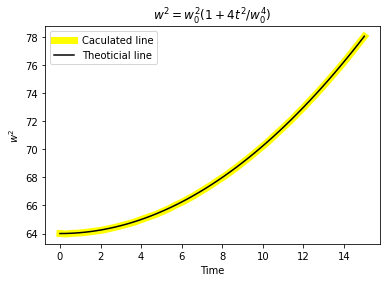

In [4]:
width2_theo = Width2_theo(w0) 
plt.plot(T,width**2,lw = 7,color = "yellow", label = "Caculated line")
plt.plot(T,width2_theo(T),"black", label = "Theoticial line")
plt.xlabel("Time")
plt.ylabel("$w^2$")
plt.title("$w^2 = w_0^2(1+4t^2/w_0^4)$")
plt.legend()

**We see that our programm past the test of the spread of gaussian wave packet.**

Now, we will find the soliton solution of the nonlinear Schrodinger equation (NLSE) using the imaginary time method. We know that the soliton is a stable solution of NLSE (in real time), so by using imaginary time method, for any initial function, we get the solution in a sufficiently long time.

0.9999999999999997
1.0000000000000004


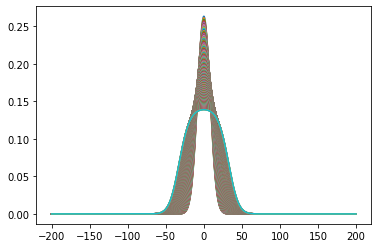

In [5]:
# Find soliton solution
w = 0           # Valeur de w dans l'equation
N = 1        # Valeur de N dans l'equation
Nx = 20000      # Nombre de pas de x
L = 200        # x_max; dx = L/Nx
Nt = 100      # Nombre de pas de temps
dt = 0.003         # Intervalle de temp
NT = 300    # Nombre de pas de T

# create a Gaussian object
w0 = 8
k0 = 0
x0 = 0
gauss = Gaussian_packet(w0,k0,x0)

# Creat constant function
class Constant:
    """Constant function"""
    def __init__(self, I0):
        self.I0 = I0
        
    def __call__(self, x):
        return self.I0

constant = Constant(0.0025)
# Create an GPE
GPE = GPE1D(Nx,N,L,w,0) 
GPE.initialize(gauss)
x = GPE.x
print(np.linalg.norm(GPE.u)**2*GPE.dx)
T,dT = np.linspace(0,NT*dt*Nt,NT+1,endpoint = True, retstep = True)
dif = np.zeros(NT+1)

# Evolve the wave function in time, we get the value of wave function each T(s) for NT times
for i in range(NT):
    u = GPE.u
    advance(GPE,dt,Nt)
    plt.plot(GPE.x, np.abs(GPE.u))
    dif[i] = np.linalg.norm(GPE.u-u)
print(np.linalg.norm(GPE.u)**2*GPE.dx)

Text(0.5, 1.0, "Fonction d'onde finale")

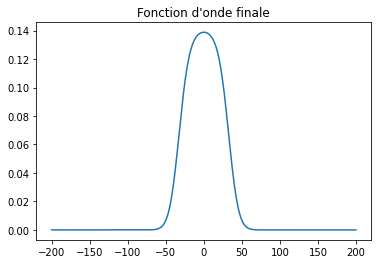

In [6]:
plt.plot(GPE.x, np.abs(GPE.u))
plt.title("Fonction d'onde finale")


Text(0.5, 1.0, '$\\int |\\psi_{n+1} - \\psi_{n} |$ en fonction du temps')

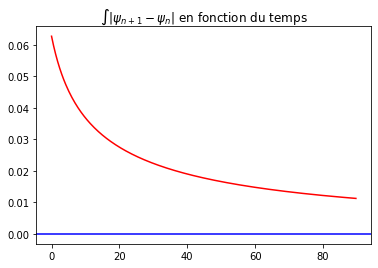

In [7]:

plt.plot(T[0:-1],dif[0:-1],"red")
plt.axhline(y=0, color='blue')
plt.title("$\int |\psi_{n+1} - \psi_{n} |$ en fonction du temps")

1.0000000000000009


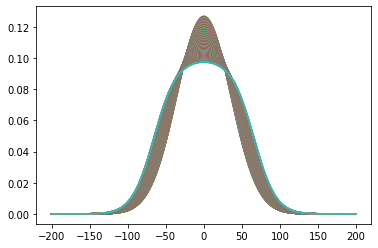

In [8]:
# Find soliton solution
w = 0           # Valeur de w dans l'equation
N = 1        # Valeur de N dans l'equation
Nx = 20000      # Nombre de pas de x
L = 200        # x_max; dx = L/Nx
Nt = 100      # Nombre de pas de temps
dt = 0.003         # Intervalle de temp
NT = 300   # Nombre de pas de T

# create a Gaussian object
w0 = 35
k0 = 0
x0 = 0
gauss = Gaussian_packet(w0,k0,x0)

# Creat constant function
class Constant:
    """Constant function"""
    def __init__(self, I0):
        self.I0 = I0
        
    def __call__(self, x):
        return self.I0

constant = Constant(0.0025)
# Create an GPE
GPE = GPE1D(Nx,N,L,w,0) 
GPE.initialize(gauss)
x = GPE.x

T,dT = np.linspace(0,NT*dt*Nt,NT+1,endpoint = True, retstep = True)
dif = np.zeros(NT+1)

# Evolve the wave function in time, we get the value of wave function each T(s) for NT times
for i in range(NT):
    u = GPE.u
    advance(GPE,dt,Nt)
    dif[i] = np.linalg.norm(GPE.u-u)
    plt.plot(GPE.x, np.abs(GPE.u))
print(np.linalg.norm(GPE.u)**2*GPE.dx)

Text(0.5, 1.0, "Fonction d'onde finale")

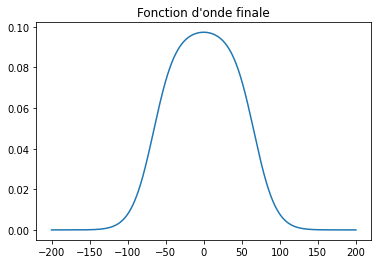

In [9]:
plt.plot(GPE.x, np.abs(GPE.u))
plt.title("Fonction d'onde finale")

Text(0.5, 1.0, '$\\int |\\psi_{n+1} - \\psi_{n} |$ en fonction du temps')

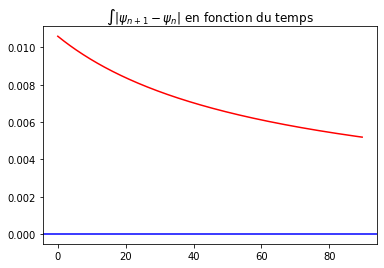

In [10]:

plt.plot(T[0:-1],dif[0:-1],"red")
plt.axhline(y=0, color='blue')
plt.title("$\int |\psi_{n+1} - \psi_{n} |$ en fonction du temps")